# Visualising a few heatmaps 

In [7]:
from torch.utils.data import DataLoader
from dataloaders.datasets import surfrider
from dataloaders.utils import decode_segmap
import matplotlib.pyplot as plt
from modeling.deeplab import *
import numpy as np 
import argparse
import torch
from matplotlib.pyplot import figure
class Args:
    def __init__(self, **kwds):
        self.__dict__.update(kwds)

# parser = argparse.ArgumentParser()
args = Args(base_size = 513,
            crop_size = 513,
            out_stride = 16,
            sync_bn = True,
            freeze_bn = False,
            resume = '/home/mathis/Documents/repos/pytorch-deeplab-xception/weights/best_trained_surfrider_only.pth.tar',
            cuda = True)

### Loading trained model 

In [8]:
model = DeepLab(num_classes=4,
                backbone='mobilenet',
                output_stride=args.out_stride,
                sync_bn=args.sync_bn,
                freeze_bn=args.freeze_bn)
checkpoint = torch.load(args.resume)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

## From TACO directly

### Creating dataloader 

In [17]:
val_set = surfrider.SURFSegmentation(args, split='val')
val_loader = DataLoader(val_set, batch_size=2, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Plotting for a few images

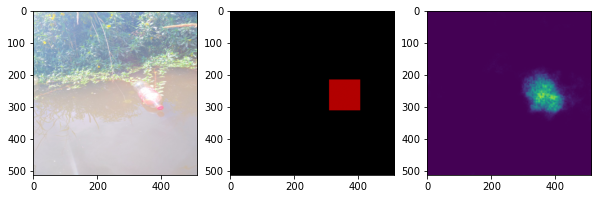

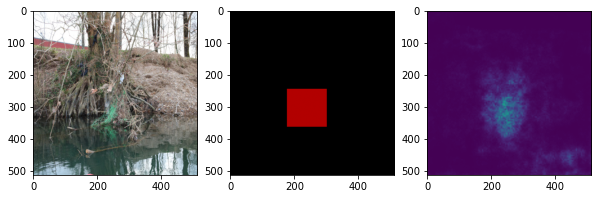

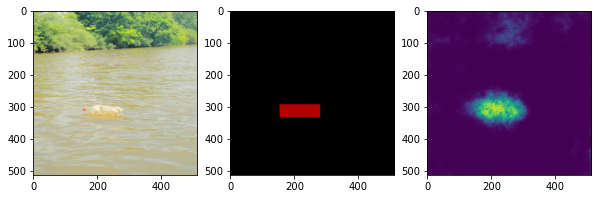

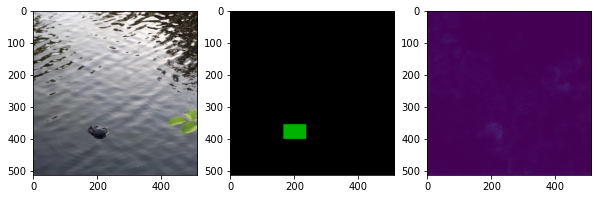

In [19]:
for ii, sample in enumerate(val_loader):
    img = sample['image']
    gt = sample['label'].numpy()
    with torch.no_grad():
        output = model(img)
        img = img.numpy()
    for jj in range(sample["image"].size()[0]):
        output_jj = output[jj,:,:,:]
        output_jj = torch.nn.functional.softmax(output_jj,dim=0).numpy()
        output_jj = np.sum(output_jj[1:,:,:],axis=0)
        output_jj = output_jj 
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, dataset='surfrider')
        img_tmp = np.transpose(img[jj], axes=[1, 2, 0])
        img_tmp *= (0.234, 0.220, 0.220)
        img_tmp += (0.498, 0.470, 0.415)
        img_tmp *= 255.0
        img_tmp = img_tmp.astype(np.uint8)
        plt.figure(figsize=(10,10))
        plt.title('display')
        plt.subplot(131)
        plt.imshow(img_tmp)
        plt.subplot(132)
        plt.imshow(segmap)
        plt.subplot(133)
        plt.imshow(output_jj,vmin=0,vmax=1)
    if ii == 1:
        break

plt.show(block=True)

## From video with overlayed TACO trash bottle 

In [12]:
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [14]:
def read_folder(input_path):
    # for now, read directly from images in folder ; later from json outputs
    return [os.path.join(input_path, file) for file in sorted(os.listdir(input_path))]

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.498, 0.470, 0.415], std=[0.234, 0.220, 0.220]),
])

dataset = ImageFolder('/home/mathis/Documents/repos/mot/notebooks/2nd_video_2fps_extracted/', transform=preprocess)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
count=0
for ii, sample in enumerate(dataloader):
    img = sample[0]
    gt = sample[1].numpy()
    with torch.no_grad():
        output = model(img)
        img = img.numpy()
    for jj in range(sample[0].size()[0]):
        output_jj = output[jj,:,:,:]
        output_jj = torch.nn.functional.softmax(output_jj,dim=0).numpy()
        output_jj = np.sum(output_jj[1:,:,:],axis=0)
        output_jj = output_jj 
        img_tmp = np.transpose(img[jj], axes=[1, 2, 0])
        img_tmp *= (0.234, 0.220, 0.220)
        img_tmp += (0.498, 0.470, 0.415)
        img_tmp *= 255.0
        img_tmp = img_tmp.astype(np.uint8)
        plt.figure(figsize=(15,15))
        plt.title('display')
        plt.subplot(121)
        plt.imshow(img_tmp)
        plt.subplot(122)
        plt.imshow(output_jj,vmin=0,vmax=1)
        plt.savefig('image_{}'.format(count))
        count+=1
    plt.show(block=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mathis/Documents/repos/mot/notebooks/2nd_video_2fps_extracted/'